# DSCI552: HW4

# Part II: Tree Based Methods  

***Name: Cheng Peng***


***USC ID: 6898-9638-37***

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sn 
import matplotlib.pyplot as plt
import math
import seaborn as sn 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
import weka.core.jvm as jvm
from weka.classifiers import Classifier, Evaluation
import weka.core.converters as converters
from weka.core.classes import Random
import weka.plot.classifiers as plcls
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE


# a): Download Data

In [2]:
#train_url = "/content/drive/My Drive/DSCI552/Homework 4 Data/data/aps_failure_training_set.csv"
#test_url = "/content/drive/My Drive/DSCI552/Homework 4 Data/data/aps_failure_test_set.csv"
train_url="../data/aps_failure_training_set.csv"
test_url = "../data/aps_failure_test_set.csv"
df_train = pd.read_csv(train_url, skiprows=20)
df_test = pd.read_csv(test_url, skiprows=20)

# b): Data Preparation 

i: missing values

In [3]:
df_train.replace("na", np.nan, inplace=True)
df_test.replace("na", np.nan, inplace=True)
# split into x and y 
train_x, train_y = df_train.iloc[:,1:], df_train.iloc[:,0]
test_x, test_y = df_test.iloc[:,1:], df_test.iloc[:,0]

# data imputation 
imputer = SimpleImputer(missing_values = np.nan, strategy="mean").fit(train_x)
train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)



In [4]:
train_x = pd.DataFrame(train_x, columns = df_train.columns.values[1:])
test_x = pd.DataFrame(test_x, columns = df_test.columns.values[1:])

In [5]:
train_x.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [6]:
test_x.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0,0.000000,20.0,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82.0,0.000000,68.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002.0,2.000000,212.0,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816.0,0.713189,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814.0,0.713189,156.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


ii: Calculate CV 

In [20]:
def CoefVar(x):
    return x.std()/x.mean()

coeff_var = train_x.agg(["std", "mean", CoefVar])
coeff_var.index = ["std", "mean", "cv"]

In [21]:
coeff_var

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
std,145430.056532,1.660588,7.724678e+08,3.504515e+07,158.142022,205.375337,20363.631242,34008.750683,149479.100501,757459.796689,...,1.149060e+06,540272.166338,1.161763e+06,1.114758e+06,1.063164e+06,1.718366e+06,446989.425928,47204.242869,4.268529,8.627929
mean,59336.499567,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,221.636367,975.722261,8606.014529,88591.281094,...,4.454897e+05,211126.447302,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,138729.983179,8388.914629,0.090579,0.212756
cv,2.450938,2.328400,2.169767e+00,1.838476e+02,23.190937,18.658921,91.878565,34.854950,17.369143,8.550049,...,2.579319e+00,2.558998,2.606402e+00,2.829722e+00,3.192128e+00,4.962483e+00,3.222010,5.626979,47.124953,40.553250


iii: Correlation Matrix 

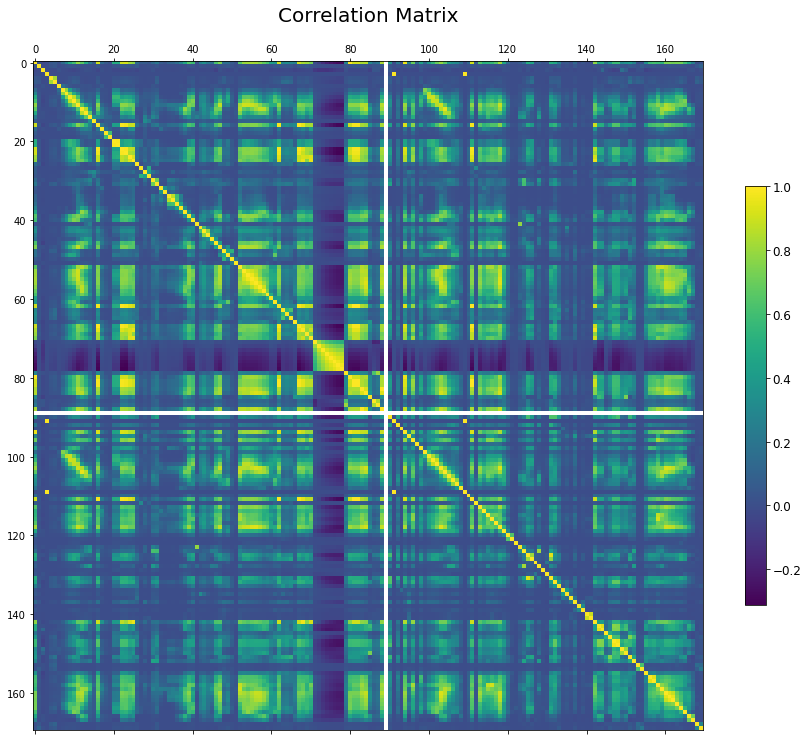

In [ ]:
corr_matrix = train_x.corr()
figure = plt.figure(figsize=(15,15))
plt.matshow(corr_matrix, fignum = figure.number)
colour_bar = plt.colorbar(shrink = 0.5)
colour_bar.ax.tick_params(labelsize = 12)
plt.title("Correlation Matrix", fontsize = 20)
plt.show()

iv: Scatter Plot 

In [22]:
n = math.floor(math.sqrt(170))
top_n = list(coeff_var.loc["cv"].nlargest(n).index.values)
top_n = train_x[top_n].copy()
top_n["class"] = list(train_y)

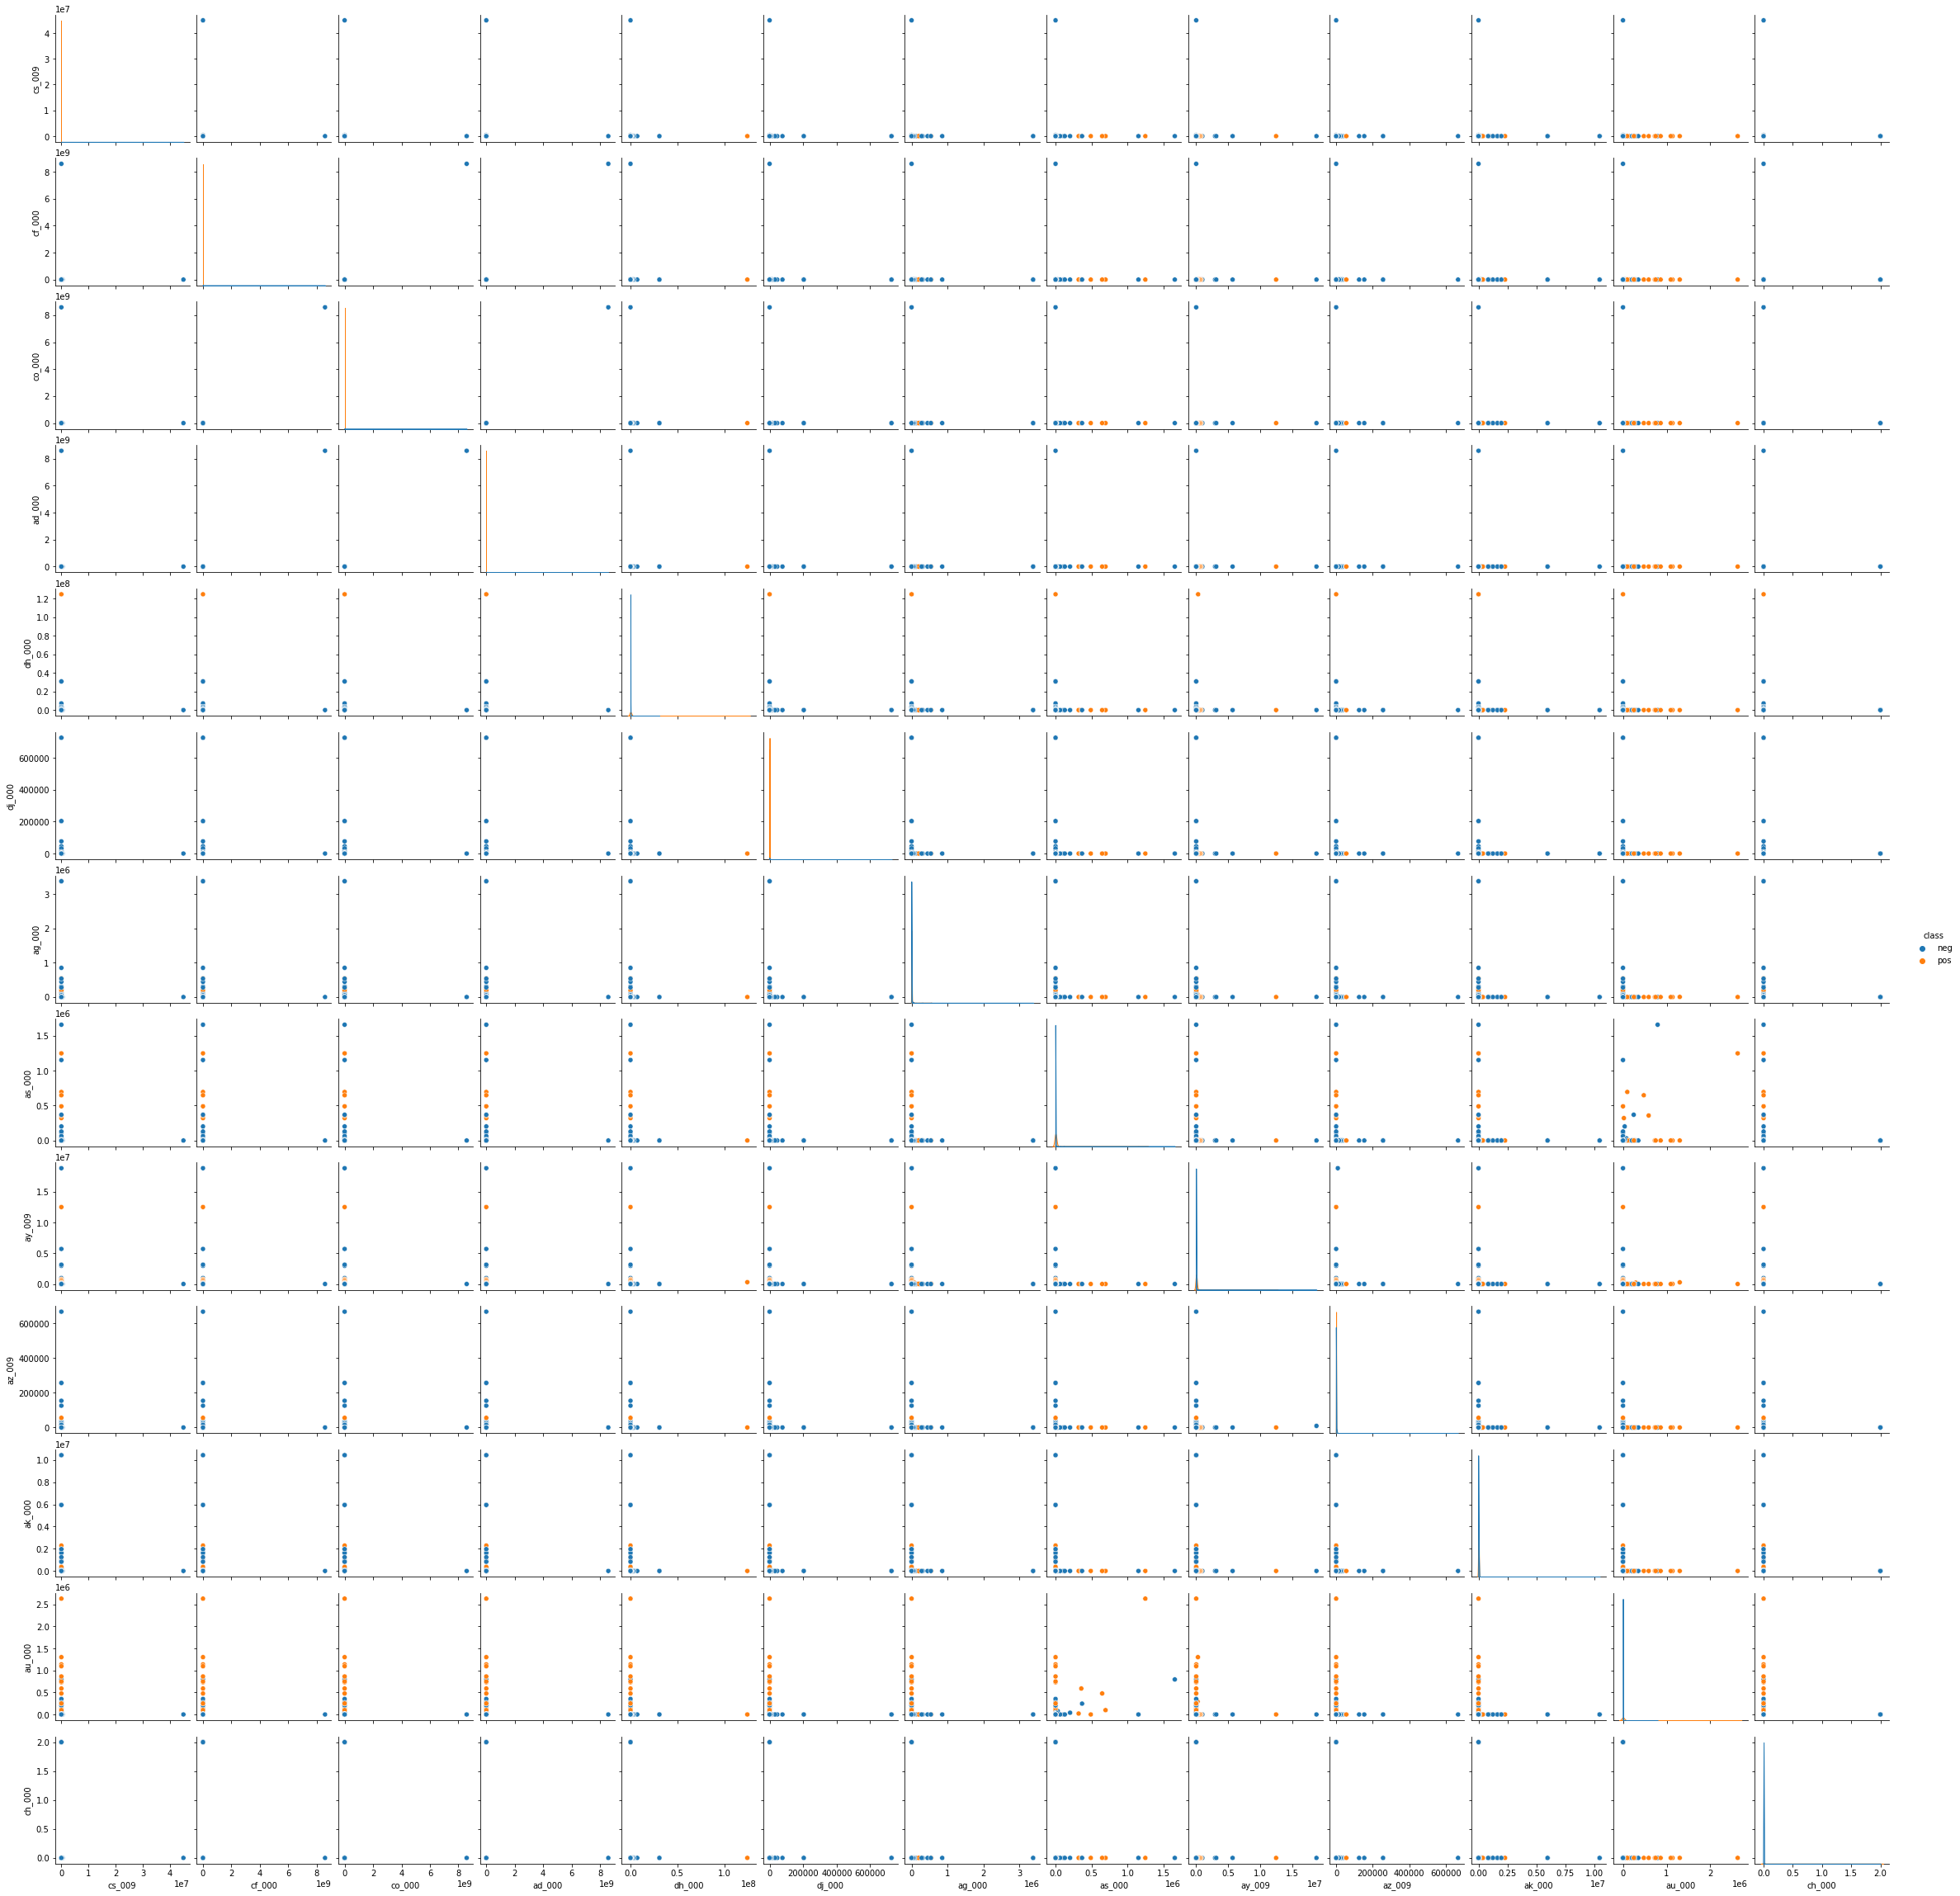

In [ ]:
sn.pairplot(top_n, hue = "class")
plt.show()

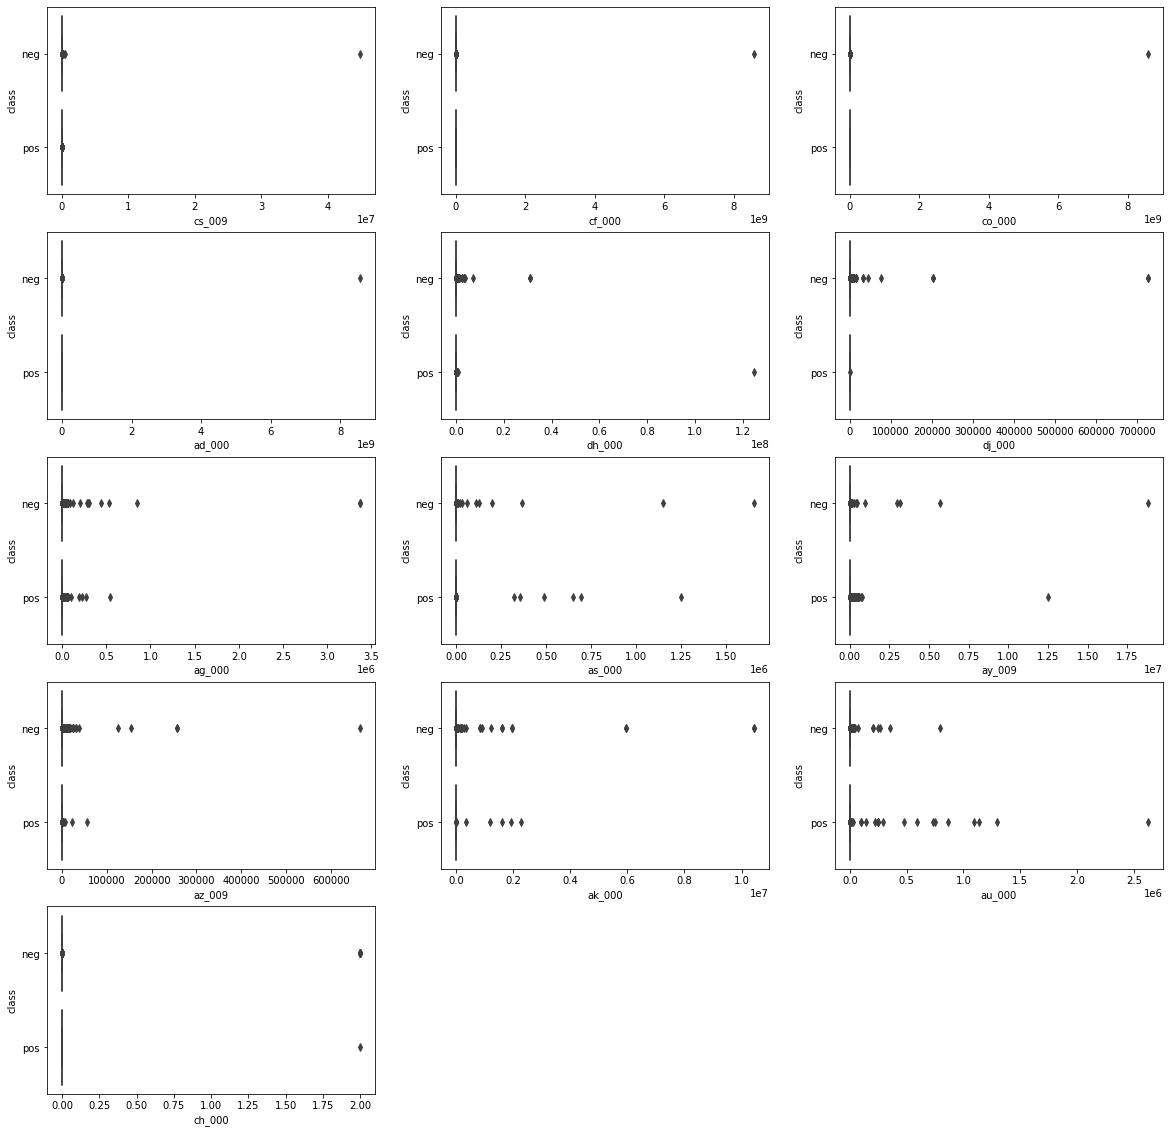

In [ ]:
plt.figure(figsize=(20,20))
for i, column in enumerate(top_n):
    if column !="class":
        figure = plt.subplot(5, 3, i+1)
        axs = sn.boxplot(x = top_n[column], y = train_y)
plt.show()


***Comment:*** Based on the plots, it is hard to draw conclusion about the significance of the features. 

v: number of positive class and negative class

In [ ]:
neg = len(df_train[df_train["class"]=="neg"])
pos = len(df_train[df_train["class"]=="pos"])
print("There are {} negative class samples and {} positive class samples".format(neg, pos))

There are 59000 negative class samples and 1000 positive class samples


***Comment:*** The dataset is imbalanced, it contains more negative class samples than positive ones. 

# C): Random Forest without Compensating Class Imbalance

In [48]:
# mask the class neg -> 0, pos ->1
train_y = df_train["class"].copy()
test_y = df_test["class"].copy()

In [49]:
train_y = train_y.apply(lambda x: 0 if x == "neg" else 1)
test_y = test_y.apply(lambda x: 0 if x == "neg" else 1)

In [50]:
model = RandomForestClassifier(max_depth = 5, random_state=1).fit(train_x, train_y)
predict_train = model.predict(train_x)
predict_test = model.predict(test_x)

In [65]:
conf_train = confusion_matrix(train_y, predict_train)
conf_train = pd.DataFrame(conf_train, columns = ["Predicted 0", "Predicted 1"], index = ["Actual 0", "Actual 1"])
conf_test = confusion_matrix(test_y, predict_test)
conf_test = pd.DataFrame(conf_test, columns = ["Predicted 0", "Predicted 1"], index = ["Actual 0", "Actual 1"])
print("Traing Set Confusion Matrix")
conf_train


Traing Set Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,58979,21
Actual 1,451,549


In [62]:
print("Test Set Confusion Matrix")
conf_test

Test Set Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,15614,11
Actual 1,183,192


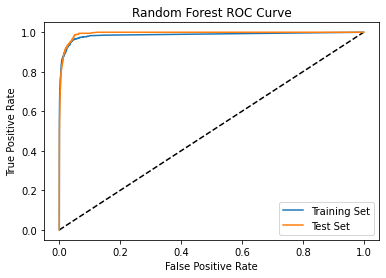

In [71]:
train_prob = model.predict_proba(train_x)[:, 1]
test_prob = model.predict_proba(test_x)[:, 1]

fpr_train, tpr_train, threshold = roc_curve(train_y, train_prob)
fpr_test, tpr_test, threshold = roc_curve(test_y, test_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_train, tpr_train, label = "Training Set")
plt.plot(fpr_test, tpr_test, label = "Test Set")
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [73]:
auc_train = accuracy_score(train_y, predict_train)
auc_test = accuracy_score(test_y, predict_test)
print("Training ACU = {:.4f} | Test AUC = {:.4f}".format(auc_train, auc_test))

Training ACU = 0.9921 | Test AUC = 0.9879


In [76]:
# out of bag score 
model = RandomForestClassifier(random_state=1, max_depth=5, oob_score=True).fit(train_x, train_y)
print("The Out of Bag error = {:.4f}".format(1-model.oob_score_))
print("The Test set error = {:.4f}".format(1-model.score(test_x, test_y)))

The Out of Bag error = 0.0092
The Test set error = 0.0121


# D): Random Forest with Compensating of Class Imbalance 

***Comment:*** There are multiple ways to compensating for class imbalance, since we are going to implement SMOTE on the dataset laster, we are going to use class_weight to deal with class imbalance here. 

In [78]:
model = RandomForestClassifier(random_state=1, max_depth=5, class_weight="balanced", oob_score=True).fit(train_x, train_y)
predict_train = model.predict(train_x)
predict_test = model.predict(test_x)

In [79]:
conf_train = confusion_matrix(train_y, predict_train)
conf_train = pd.DataFrame(conf_train, columns = ["Predicted 0", "Predicted 1"], index = ["Actual 0", "Actual 1"])
conf_test = confusion_matrix(test_y, predict_test)
conf_test = pd.DataFrame(conf_test, columns = ["Predicted 0", "Predicted 1"], index = ["Actual 0", "Actual 1"])
print("Traing Set Confusion Matrix")
conf_train


Traing Set Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,56586,2414
Actual 1,29,971


In [80]:
print("Test Set Confusion Matrix")
conf_test

Test Set Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,15006,619
Actual 1,14,361


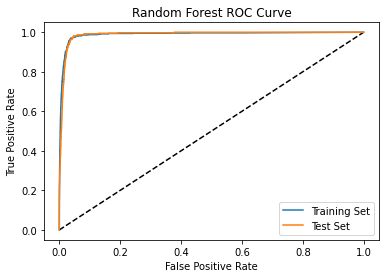

In [81]:
train_prob = model.predict_proba(train_x)[:, 1]
test_prob = model.predict_proba(test_x)[:, 1]

fpr_train, tpr_train, threshold = roc_curve(train_y, train_prob)
fpr_test, tpr_test, threshold = roc_curve(test_y, test_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_train, tpr_train, label = "Training Set")
plt.plot(fpr_test, tpr_test, label = "Test Set")
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [82]:
auc_train = accuracy_score(train_y, predict_train)
auc_test = accuracy_score(test_y, predict_test)
print("Training ACU = {:.4f} | Test AUC = {:.4f}".format(auc_train, auc_test))

Training ACU = 0.9593 | Test AUC = 0.9604


In [83]:
print("The Out of Bag error = {:.4f}".format(1-model.oob_score_))
print("The Test set error = {:.4f}".format(1-model.score(test_x, test_y)))

The Out of Bag error = 0.0418
The Test set error = 0.0396


***Comment:*** The true positive rates of both the training set and test set have increased significantly after applying inverse weight to the class frequencies, which means that the model has learned to predict the less commen class better(in this case the positive class) and with higher accuracy. Even though the overall test accuray rate does not chnage significantly, the model has benefitted from compensating for the imbalance in the dataset.  

# E): Model Trees

In [9]:
# turn on the jvm 
jvm.start()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/runnablequeue.jar', '/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/cpython.jar', '/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [10]:
train_y = df_train["class"].copy()
test_y = df_test["class"].copy()

In [11]:
# export the training set and test sets 
train = pd.concat([train_x, train_y], axis = 1)
test = pd.concat([test_x, test_y], axis = 1)

In [13]:
train.to_csv("train_set.csv", index = False)
test.to_csv("test_set.csv", index = False)

In [14]:
train_data = converters.load_any_file("train_set.csv")
test_data = converters.load_any_file("test_set.csv")
train_data.class_is_last()
test_data.class_is_last()
model = Classifier(classname="weka.classifiers.trees.LMT")
evluation = Evaluation(train_data)
evluation.crossvalidate_model(model, train_data, 10, Random(0)) 

In [16]:
print(evluation.summary())
print(evluation.class_details())


Correctly Classified Instances       59531               99.2183 %
Incorrectly Classified Instances       469                0.7817 %
Kappa statistic                          0.7454
Mean absolute error                      0.0106
Root mean squared error                  0.0819
Relative absolute error                 32.4356 %
Root relative squared error             63.9634 %
Total Number of Instances            60000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.299    0.995      0.997    0.996      0.747    0.951     0.997     neg
                 0.701    0.003    0.805      0.701    0.749      0.747    0.951     0.749     pos
Weighted Avg.    0.992    0.294    0.992      0.992    0.992      0.747    0.951     0.993     



In [20]:
conf = evluation.confusion_matrix
conf = pd.DataFrame(conf, columns = ["Predicted 0", "Predicted 1"], index = ["Actual 0", "Actual 1"])
print("Traing Set Confusion Matrix")
conf

Traing Set Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,58830.0,170.0
Actual 1,299.0,701.0


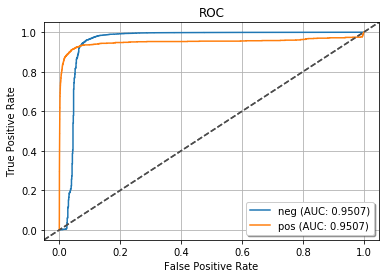

In [22]:
plcls.plot_roc(evluation, class_index=["0", "1"], wait=True)

***Comment:*** the training AUC is ROC area = 0.951 from the class_details

In [26]:
# test set 
model.build_classifier(train_data)
evluation_test = Evaluation(test_data)
evluation_test.test_model(model, test_data) 

array([0., 0., 0., ..., 0., 0., 0.])

In [27]:
print(evluation_test.summary())
print(evluation_test.class_details())


Correctly Classified Instances       15847               99.0438 %
Incorrectly Classified Instances       153                0.9563 %
Kappa statistic                          0.775 
Mean absolute error                      0.0126
Root mean squared error                  0.0873
Relative absolute error                 27.4181 %
Root relative squared error             57.6799 %
Total Number of Instances            16000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.277    0.993      0.997    0.995      0.778    0.975     0.998     neg
                 0.723    0.003    0.847      0.723    0.780      0.778    0.975     0.816     pos
Weighted Avg.    0.990    0.271    0.990      0.990    0.990      0.778    0.975     0.994     



In [28]:
conf_test = evluation_test.confusion_matrix
conf_test = pd.DataFrame(conf_test, columns = ["Predicted 0", "Predicted 1"], index = ["Actual 0", "Actual 1"])
print("Traing Set Confusion Matrix")
conf_test

Traing Set Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,15576.0,49.0
Actual 1,104.0,271.0


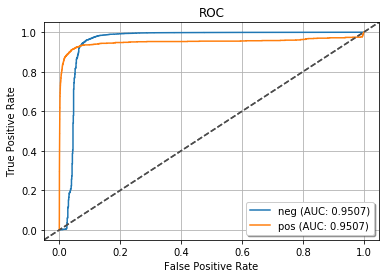

In [29]:
plcls.plot_roc(evluation, class_index=["0", "1"], wait=True)

***Comment:*** The test AUC is 0.975.

# F): SMOTE 

***Note:*** fot this section, I first tried downsampling then applied SMOTE because I did not know how much time it would take. It was actually pretty fast considering the training set had 12,000 samples. Then I did SMOTE without downsampling which produced 118,000 samples, and it took a night to finish running. I am going to present the resutls of both methods below. 

    

***SMOTE WITH DOWNSAMPLING***

In [11]:
# try the down sample first 
# downsample the common class to 6000, in this case, the common class is negative 
train_set = pd.concat([train_x, train_y], axis = 1)
train_neg = train_set[train_set["class"]=="neg"]
train_pos = train_set[train_set["class"]=="pos"]
train_neg_down = resample(train_neg, random_state = 1, n_samples = 6000, replace = False)
train_set_downsampled = pd.concat([train_neg_down, train_pos], axis=0)
train_x_down = train_set_downsampled.drop(["class"], axis=1)
train_x_down.reset_index(drop = True, inplace = True)
train_y_down = train_set_downsampled["class"]
train_y_down.reset_index(inplace=True, drop = True)
smote = SMOTE(random_state=1)
train_x_smote, train_y_smote = smote.fit_resample(train_x_down, train_y_down)
train_x_smote = pd.DataFrame(train_x_smote, columns = train_x_down.columns)
train_y_smote = pd.DataFrame(train_y_smote, columns=["class"])

In [12]:
print("After downsampling the common class to 6000 and apply SMOTE, there are {} training samples which {} are of the positive class, and {} of the negative class.".format(len(train_x_smote), len(train_y_smote[train_y_smote["class"]=="pos"]), len(train_y_smote[train_y_smote["class"]=="neg"])))

After downsampling the common class to 6000 and apply SMOTE, there are 12000 training samples which 6000 are of the positive class, and 6000 of the negative class.


In [13]:
jvm.start()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/runnablequeue.jar', '/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/cpython.jar', '/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [14]:
train_down_smote = pd.concat([train_x_smote, train_y_smote], axis=1)
train_down_smote.to_csv("train_down_smote.csv", index=False)
train_data = converters.load_any_file("train_down_smote.csv")
train_data.class_is_last()
model = Classifier(classname="weka.classifiers.trees.LMT")
evluation = Evaluation(train_data)
evluation.crossvalidate_model(model, train_data, 5, Random(0)) 

In [15]:
print(evluation.summary())
print(evluation.class_details())


Correctly Classified Instances       11670               97.25   %
Incorrectly Classified Instances       330                2.75   %
Kappa statistic                          0.945 
Mean absolute error                      0.04  
Root mean squared error                  0.1552
Relative absolute error                  8.0099 %
Root relative squared error             31.0423 %
Total Number of Instances            12000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.966    0.021    0.978      0.966    0.972      0.945    0.987     0.986     neg
                 0.979    0.034    0.967      0.979    0.973      0.945    0.987     0.980     pos
Weighted Avg.    0.973    0.028    0.973      0.973    0.972      0.945    0.987     0.983     



In [16]:
conf = evluation.confusion_matrix
conf = pd.DataFrame(conf, columns = ["Predicted 0", "Predicted 1"], index = ["Actual 0", "Actual 1"])
print("Traing Set Confusion Matrix")
conf

Traing Set Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,5798.0,202.0
Actual 1,128.0,5872.0


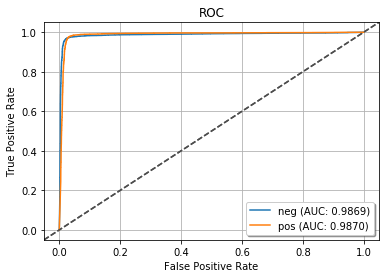

In [17]:
plcls.plot_roc(evluation, class_index=["0", "1"], wait=True)

***Comment:*** The train AUC is 0.987.

In [19]:
test_data = converters.load_any_file("test_set.csv")
test_data.class_is_last()
# test set 
model.build_classifier(train_data)
evluation_test = Evaluation(test_data)
evluation_test.test_model(model, test_data) 

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
print(evluation_test.summary())
print(evluation_test.class_details())


Correctly Classified Instances       15524               97.025  %
Incorrectly Classified Instances       476                2.975  %
Kappa statistic                          0.5651
Mean absolute error                      0.0353
Root mean squared error                  0.159 
Relative absolute error                 77.1187 %
Root relative squared error            105.0876 %
Total Number of Instances            16000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.973    0.128    0.997      0.973    0.985      0.603    0.956     0.998     neg
                 0.872    0.027    0.433      0.872    0.579      0.603    0.956     0.633     pos
Weighted Avg.    0.970    0.126    0.984      0.970    0.975      0.603    0.956     0.990     



In [21]:
conf_test = evluation_test.confusion_matrix
conf_test = pd.DataFrame(conf_test, columns = ["Predicted 0", "Predicted 1"], index = ["Actual 0", "Actual 1"])
print("Traing Set Confusion Matrix")
conf_test

Traing Set Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,15197.0,428.0
Actual 1,48.0,327.0


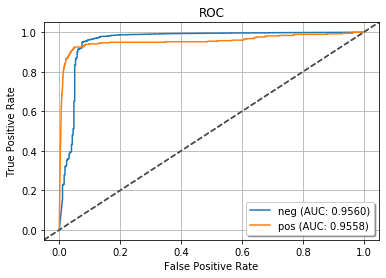

In [23]:
plcls.plot_roc(evluation_test, class_index=["0", "1"], wait=True)

***Comment:*** the test AUC is 0.956

***SMOTE WITHOUT DOWNSAMPLING***

In [7]:
jvm.start()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/runnablequeue.jar', '/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/cpython.jar', '/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/patrickpeng/opt/anaconda3/lib/python3.7/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [8]:
# now do SMOTE on the entire training set without downsampling 
train_set = pd.concat([train_x, train_y], axis = 1)
smote = SMOTE(random_state=1)
train_x_smote, train_y_smote = smote.fit_resample(train_x, train_y)
train_x_smote = pd.DataFrame(train_x_smote, columns = train_x.columns.values)
train_y_smote = pd.DataFrame(train_y_smote, columns=["class"])

In [9]:
print("After applying SMOTE, there are {} training samples which {} are of the positive class, and {} of the negative class.".format(len(train_x_smote), len(train_y_smote[train_y_smote["class"]=="pos"]), len(train_y_smote[train_y_smote["class"]=="neg"])))

After applying SMOTE, there are 118000 training samples which 59000 are of the positive class, and 59000 of the negative class.


In [11]:
train_smote = pd.concat([train_x_smote, train_y_smote], axis=1)
train_smote.to_csv("train_smote.csv", index=False)
train_data = converters.load_any_file("train_smote.csv")
train_data.class_is_last()
model = Classifier(classname="weka.classifiers.trees.LMT")
evluation = Evaluation(train_data)
evluation.crossvalidate_model(model, train_data, 5, Random(0)) 

In [12]:
print(evluation.summary())
print(evluation.class_details())


Correctly Classified Instances      116214               98.4864 %
Incorrectly Classified Instances      1786                1.5136 %
Kappa statistic                          0.9697
Mean absolute error                      0.0246
Root mean squared error                  0.1125
Relative absolute error                  4.9229 %
Root relative squared error             22.4981 %
Total Number of Instances           118000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.985    0.015    0.985      0.985    0.985      0.970    0.996     0.995     neg
                 0.985    0.015    0.985      0.985    0.985      0.970    0.996     0.994     pos
Weighted Avg.    0.985    0.015    0.985      0.985    0.985      0.970    0.996     0.994     



In [13]:
conf = evluation.confusion_matrix
conf = pd.DataFrame(conf, columns = ["Predicted 0", "Predicted 1"], index = ["Actual 0", "Actual 1"])
print("Traing Set Confusion Matrix")
conf

Traing Set Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,58120.0,880.0
Actual 1,906.0,58094.0


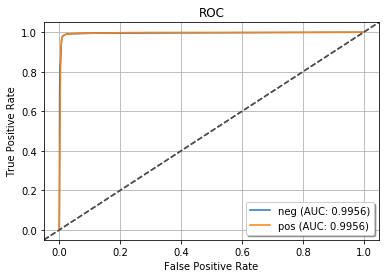

In [14]:
plcls.plot_roc(evluation, class_index=["0", "1"], wait=True)

***Comment:*** The training AUC is 0.996

In [15]:
test_data = converters.load_any_file("test_set.csv")
test_data.class_is_last()
# test set 
model.build_classifier(train_data)
evluation_test = Evaluation(test_data)
evluation_test.test_model(model, test_data) 

array([0., 0., 0., ..., 0., 0., 0.])

In [16]:
print(evluation_test.summary())
print(evluation_test.class_details())


Correctly Classified Instances       15694               98.0875 %
Incorrectly Classified Instances       306                1.9125 %
Kappa statistic                          0.6678
Mean absolute error                      0.0293
Root mean squared error                  0.1265
Relative absolute error                 64.0189 %
Root relative squared error             83.6431 %
Total Number of Instances            16000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.984    0.144    0.996      0.984    0.990      0.684    0.918     0.994     neg
                 0.856    0.016    0.560      0.856    0.677      0.684    0.918     0.747     pos
Weighted Avg.    0.981    0.141    0.986      0.981    0.983      0.684    0.918     0.988     



In [17]:
conf_test = evluation_test.confusion_matrix
conf_test = pd.DataFrame(conf_test, columns = ["Predicted 0", "Predicted 1"], index = ["Actual 0", "Actual 1"])
print("Traing Set Confusion Matrix")
conf_test

Traing Set Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,15373.0,252.0
Actual 1,54.0,321.0


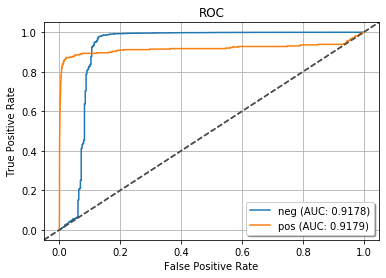

In [18]:
plcls.plot_roc(evluation_test, class_index=["0", "1"], wait=True)

***Comment:*** The test AUC is 0.9179

***Conclusion:*** By balancing the class in the training set using SMOTE, the model tree is able to achieve very high training accuracy rate over both classes. However, the test accuracy rate does not improve. 